<a href="https://colab.research.google.com/github/lochieh19798/Data-analysis/blob/main/Figure2mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ╔═╡ Cell 0 ═════════════════════════════════════════════════════════════╗
# If you’re on Colab, install any non-preinstalled libraries:
!pip install -q catboost shap scikit-learn==1.4.2 matplotlib pandas numpy
!pip install -q --upgrade xgboost
!pip install -q shap --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.5 MB/s eta 0:00:00


In [ ]:
from xgboost.sklearn import XGBModel
XGBModel.feature_weights = None
print("Patched XGBModel.feature_weights →", XGBModel.feature_weights)

Patched XGBModel.feature_weights → None


In [ ]:
# ╔═╡ Cell 1 ═════════════════════════════════════════════════════════════╗
# Imports & global configuration
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import display

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer
    # ← no IterativeImputer here
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
plt.style.use("default")


In [ ]:
# ╔═╡ Cell 2 – load data & build feature lists with missing‐% report ═════╝
from pathlib import Path
import pandas as pd

# 1. Data‐loading helper (as before)
def load_and_prepare_data(csv_path: str = "/content/CRYOANALYSIS.csv") -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # (1) Recurrence flags
    df["Survival_time"] = pd.to_numeric(df["Survival_time"], errors="coerce")
    df = df.dropna(subset=["Survival_time", "Recurrence"])
    df["Recurrence_1yr"] = ((df["Survival_time"] <= 365) & (df["Recurrence"] == 1)).astype(int)
    df["Recurrence_2yr"] = ((df["Survival_time"] <= 730) & (df["Recurrence"] == 1)).astype(int)
    # (2) AF type one‐hot
    af_col = "Baseline AF Type(1=paroxysmal, 2=persistent)"
    df["AF_Parox"]   = (df[af_col] == 1).astype(int)
    df["AF_Persist"] = (df[af_col] == 2).astype(int)
    return df

# 2. Load the dataset
DATA_PATH = Path("/content/CRYOANALYSIS.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found – upload it first!"
df = load_and_prepare_data(DATA_PATH)

# 3. Feature lists
cont = [
    "age", "BMI",
    "Baseline LVEF", "Baseline LAD", "CHA2DS2VASc score", "CHAD2 score", "AF_time_procedure",
    "Total no of ablation application number", "Mobility question (Baseline)",
    "Self-care question (Baseline)", "Usual activities question (Baseline)",
    "Pain/Discomfort question (Baseline)", "Anxiety/Depression question (Baseline)",
    "Visual analogue score: Your own health state today (Baseline)",
    "Total procedure time: Venous access to last cryoatheter removal (mins)",
    "Total fluoro time (mins)", "Energy duration LSPV", "Coldest Temperature LSPV", "Time to isolation LSPV",
    "Energy duration LIPV", "Coldest Temperature LIPV", "Time to isolation LIPV",
    "Energy duration RSPV", "Coldest temperature RSPV", "Time to isolation RSPV",
    "Energy duration RIPV", "Coldest Temperature RIPV", "Time to isolation RIPV",
    "Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)",
    "Change in EQ 5D"
]

cat = [
    "Sex (F=1, M=0)", "Hypertension", "Diabetes", "HF", "CAD", "stroke",
    "History of TIA", "Subject taking Class I or III AAD at baseline (1=Yes, 0=No)",
    "LSPV isolated", "LIPV PV isolated", "RSPV Isolated", "RIPV isolated",
    "Were all targeted PVs isolated (Investigator)?",
    "AF_Parox", "AF_Persist",
    "CTI ablation",
    "Non-PVI ablation performed",
    "Was subject taking Class I or Class III AAD at procedure discharge?",
    "Mapping/navigational tools: Intracardiac echocardiography (ICE)",
    "Pre Procedural CT",
    "Ensite 3D mapping"
]

TARGET = "Recurrence_2yr"

# 4. Report missing‐value percentages for every feature
all_feats = cont + cat
missing_pct = df[all_feats].isna().mean() * 100
missing_report = (
    missing_pct
      .sort_values(ascending=False)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "variable"})
)
print("📊 Missing Value Percentage per Feature:")
print(missing_report.to_string(index=False, float_format="%.1f%%"))

# 5. Gentle column check: warn & drop if still missing
missing_cont = [c for c in cont if c not in df.columns]
missing_cat  = [c for c in cat  if c not in df.columns]
if missing_cont or missing_cat:
    print("\n⚠️  WARNING – some expected columns are missing and will be skipped.")
    print("   Missing continuous :", missing_cont)
    print("   Missing categorical:", missing_cat)

cont = [c for c in cont if c in df.columns]
cat  = [c for c in cat  if c in df.columns]

# From here on, the rest of the notebook runs as before...


📊 Missing Value Percentage per Feature:
                                                                                          variable  missing_pct
                                                                            Time to isolation RIPV        73.3%
                                                                            Time to isolation RSPV        55.5%
                                                                            Time to isolation LIPV        54.1%
                                                                            Time to isolation LSPV        35.6%
                                                                                      Baseline LAD        32.7%
                                                                                   Change in EQ 5D        27.0%
                                                              Usual activities question (Baseline)        25.6%
                                                            Anxi

In [ ]:
# ╔═╡ Cell 3 ═════════════════════════════════════════════════════════════╗
# ------------- 3. Train / test split -----------------------------------
X = df[cont + cat]
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ------------- 3. Temporal hold-out (last 20% of patients) -------------
# (instead of sklearn.train_test_split)

# 1) Make sure your date column is a datetime type:
df["ProcedureDate"] = pd.to_datetime(df["ProcedureDate"])

# 2) Sort end-to-end by that date
df_sorted = df.sort_values("ProcedureDate")

# 3) Compute split index (80% training, 20% “future” test)
n = len(df_sorted)
cutoff = int(n * 0.8)

# 4) Slice off the last 20% as test
train_df = df_sorted.iloc[:cutoff]
test_df  = df_sorted.iloc[cutoff:]

# 5) Build X / y for each
X_train = train_df[cont + cat]
y_train = train_df[TARGET].astype(int)

X_test  = test_df [cont + cat]
y_test  = test_df [TARGET].astype(int)

print(f"🔎 Temporal split: {len(train_df)} train rows, {len(test_df)} test rows")

# ╔═╡ Cell 4 ═════════════════════════════════════════════════════════════╗
# ------------- 4. Pre-processing pipelines -----------------------------
numeric_pipe = Pipeline(steps=[
    ("impute", KNNImputer(
        n_neighbors=5,        # tweak k as you like
        weights="uniform"     # or "distance"
    )),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("ordinal", OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )),
    ("impute", KNNImputer(n_neighbors=5)),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

🔎 Temporal split: 224 train rows, 57 test rows


In [ ]:
# ╔═╡ Cell 4b – preview KNN imputation on numeric features ══════════════╗

# 1. Show missing counts before
num_train = X_train[cont].copy()
print("🔴 Missing before imputation (numeric features):")
print(num_train.isna().sum())

# 2. Fit & transform with your numeric_pipe
num_imputed = pd.DataFrame(
    numeric_pipe.fit_transform(num_train),
    columns=cont,
    index=num_train.index
)

# 3. Show missing counts after
print("\n🟢 Missing after KNN imputation:")
print(num_imputed.isna().sum())

# 4. Display first few rows of the imputed DataFrame
display(num_imputed.head())


🔴 Missing before imputation (numeric features):
age                                                                                                     0
BMI                                                                                                     1
Baseline LVEF                                                                                          65
Baseline LAD                                                                                           90
CHA2DS2VASc score                                                                                       0
CHAD2 score                                                                                             0
AF_time_procedure                                                                                      27
Total no of ablation application number                                                                 0
Mobility question (Baseline)                                                                           1

,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Coldest Temperature LIPV,Time to isolation LIPV,Energy duration RSPV,Coldest temperature RSPV,Time to isolation RSPV,Energy duration RIPV,Coldest Temperature RIPV,Time to isolation RIPV,Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins),Change in EQ 5D
75,0.494305,-0.624738,0.494709,0.072510,-0.548916,-0.901004,-0.638890,-0.232568,-0.304439,-0.19657,...,-0.103859,1.200876,0.101515,-0.836620,-0.566909,-0.032317,-0.370837,-1.010991,-0.818048,0.029075
76,-1.956844,-0.651063,-1.229188,-0.034347,1.728069,2.371831,-0.454142,-0.738348,-0.304439,-0.19657,...,0.614179,-0.620030,-0.362950,-0.106517,-1.209071,-1.328848,1.054481,0.002685,-0.182022,0.029075
77,-0.689008,1.586610,0.362101,0.713646,0.210079,0.189941,-0.551327,-0.232568,-0.304439,-0.19657,...,0.255160,-0.662708,-0.222530,-1.128661,-0.566909,-0.032317,-0.370837,-0.955295,-0.668395,0.665099
78,1.001439,0.559913,-0.831366,1.960301,1.728069,1.280886,0.044291,-0.232568,-0.304439,-0.19657,...,-2.976010,0.304649,-0.319744,-0.690599,-0.807719,-0.032317,0.769417,-1.512260,-0.855461,0.347087
285,0.578827,-0.624738,-0.300936,-0.354915,-0.548916,0.189941,1.416425,0.273211,-0.304439,-0.19657,...,-0.103859,-0.577353,-0.427758,-0.690599,-0.165557,-1.447697,-0.228305,-1.289474,0.005044,0.029075


In [ ]:
# ╔═╡ Cell 4c – preview KNN imputation on categorical features ═══════╗
import pandas as pd

# 1. Grab the raw cat columns (with NaNs)
cat_train = X_train[cat].copy()
print("🔴 Missing before imputation (categorical):")
print(cat_train.isna().sum())

# 2. Fit & transform via categorical_pipe
cat_imputed_array = categorical_pipe.fit_transform(cat_train)

# 3. Turn back into a DataFrame for inspection
#    (OneHotEncoder with sparse_output=False → a dense array)
cat_ohe_cols = categorical_pipe.named_steps["onehot"].get_feature_names_out(cat)
cat_imputed = pd.DataFrame(cat_imputed_array, columns=cat_ohe_cols, index=cat_train.index)

print("\n🟢 Missing after KNN imputation & one-hot:")
print(cat_imputed.isna().sum().sum(), "total NaNs remaining")

print("\n🖨️ Sample of the imputed one-hot matrix:")
display(cat_imputed.iloc[:, :10].head())  # show first 10 dummy columns


🔴 Missing before imputation (categorical):
Sex (F=1, M=0)                                                          0
Hypertension                                                            0
Diabetes                                                                0
HF                                                                      0
CAD                                                                     0
stroke                                                                  0
History of TIA                                                          0
Subject taking Class I or III AAD at baseline (1=Yes, 0=No)             3
LSPV isolated                                                           2
LIPV PV isolated                                                        3
RSPV Isolated                                                           2
RIPV isolated                                                           2
Were all targeted PVs isolated (Investigator)?                       

,"Sex (F=1, M=0)_0.0","Sex (F=1, M=0)_1.0",Hypertension_0.0,Hypertension_1.0,Diabetes_0.0,Diabetes_1.0,HF_0.0,HF_1.0,CAD_0.0,CAD_1.0
75,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
76,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
77,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
78,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
285,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# ╔═╡ Cell 4d – inspect full preprocessed feature space ─══════════════╗
from sklearn.compose import ColumnTransformer

# 1) re‐build the full ColumnTransformer exactly as you’ll use in Cell 5
ct = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"
)

# 2) fit & transform your training set
X_tr_full = ct.fit_transform(X_train)

# 3) grab the final feature names
feat_names = ct.get_feature_names_out()

# 4) report
print(f"➡️  Combined train matrix shape: {X_tr_full.shape[0]} rows × {X_tr_full.shape[1]} cols")
print(f"📦  Total features = {len(feat_names)}")
print("🔍  Example feature names:", feat_names[:10], "…", feat_names[-10:])

# 5) (optional) display the first few rows in a DataFrame
import pandas as pd
df_feats = pd.DataFrame(X_tr_full, columns=feat_names, index=X_train.index)
df_feats.head()

➡️  Combined train matrix shape: 224 rows × 83 cols
📦  Total features = 83
🔍  Example feature names: ['num__age' 'num__BMI' 'num__Baseline LVEF' 'num__Baseline LAD'
 'num__CHA2DS2VASc score' 'num__CHAD2 score' 'num__AF_time_procedure'
 'num__Total no of ablation application number'
 'num__Mobility question (Baseline)' 'num__Self-care question (Baseline)'] … ['cat__Was subject taking Class I or Class III AAD at procedure discharge?_1.0'
 'cat__Mapping/navigational tools: Intracardiac echocardiography (ICE)_0.0'
 'cat__Mapping/navigational tools: Intracardiac echocardiography (ICE)_1.0'
 'cat__Pre Procedural CT_0.0' 'cat__Pre Procedural CT_0.4'
 'cat__Pre Procedural CT_0.8' 'cat__Pre Procedural CT_1.0'
 'cat__Ensite 3D mapping_0.0' 'cat__Ensite 3D mapping_0.4'
 'cat__Ensite 3D mapping_1.0']


,num__age,num__BMI,num__Baseline LVEF,num__Baseline LAD,num__CHA2DS2VASc score,num__CHAD2 score,num__AF_time_procedure,num__Total no of ablation application number,num__Mobility question (Baseline),num__Self-care question (Baseline),...,cat__Was subject taking Class I or Class III AAD at procedure discharge?_1.0,cat__Mapping/navigational tools: Intracardiac echocardiography (ICE)_0.0,cat__Mapping/navigational tools: Intracardiac echocardiography (ICE)_1.0,cat__Pre Procedural CT_0.0,cat__Pre Procedural CT_0.4,cat__Pre Procedural CT_0.8,cat__Pre Procedural CT_1.0,cat__Ensite 3D mapping_0.0,cat__Ensite 3D mapping_0.4,cat__Ensite 3D mapping_1.0
75,0.494305,-0.624738,0.494709,0.072510,-0.548916,-0.901004,-0.638890,-0.232568,-0.304439,-0.19657,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76,-1.956844,-0.651063,-1.229188,-0.034347,1.728069,2.371831,-0.454142,-0.738348,-0.304439,-0.19657,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
77,-0.689008,1.586610,0.362101,0.713646,0.210079,0.189941,-0.551327,-0.232568,-0.304439,-0.19657,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
78,1.001439,0.559913,-0.831366,1.960301,1.728069,1.280886,0.044291,-0.232568,-0.304439,-0.19657,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
285,0.578827,-0.624738,-0.300936,-0.354915,-0.548916,0.189941,1.416425,0.273211,-0.304439,-0.19657,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# ------------- 4.3 Define candidate models ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"   # or "passthrough" if you have other cols
)

In [ ]:
# ╔═╡ Cell 4.4 – helper for CatBoost (just fill categoricals) ═════════════╗
def prepare_for_catboost(
    X: pd.DataFrame,
    cat_cols: list[str]
) -> pd.DataFrame:
    """
    Copy X, replace any NaN in the specified categorical columns
    with a literal 'Missing' string (so CatBoost sees it as a valid category).
    Leave all other columns untouched (CatBoost will handle numeric NaNs if any).
    """
    X_cb = X.copy()
    for c in cat_cols:
        X_cb[c] = X_cb[c].fillna("Missing").astype(str)
    return X_cb


In [ ]:
# # ╔═╡ Cell 4.5 — tune XGBoost rounds with native CV ═══════════════════════╗
# import xgboost as xgb

# # 1. Build DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)

# # 2. Define a base params dict (everything except n_estimators)
# xgb_params = {
#     "objective":        "binary:logistic",
#     "eval_metric":      "auc",
#     "learning_rate":    0.01,
#     "max_depth":        5,
#     "subsample":        0.8,
#     "colsample_bytree": 0.8,
#     "gamma":            1.0,
#     "reg_alpha":        0.1,
#     "reg_lambda":       1.0,
#     "scale_pos_weight": float((y_train==0).sum()) / (y_train==1).sum(),
#     "tree_method":      "hist"   # or 'auto'
# }

# # 3. Run CV with early stopping
# cv_results = xgb.cv(
#     params=xgb_params,
#     dtrain=dtrain,
#     num_boost_round=2000,
#     nfold=5,
#     metrics=("auc",),
#     early_stopping_rounds=50,
#     seed=RANDOM_STATE,
#     as_pandas=True,
#     verbose_eval=50
# )

# best_n_rounds = len(cv_results)
# best_auc = cv_results["test-auc-mean"].max()
# print(f"🔎 Optimal rounds: {best_n_rounds}, CV-AUC: {best_auc:.4f}")

In [ ]:
# ╔═╡ Cell 4.6 – Enhanced Tune of ExtraTrees via GridSearchCV ═══════╗
from sklearn.pipeline       import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble       import ExtraTreesClassifier

# 1) Pipeline: impute & one-hot → ExtraTrees
et_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", ExtraTreesClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

# 2) Expanded grid over key hyperparameters
param_grid = {
    "clf__n_estimators":    [100, 300, 500, 800],
    "clf__max_depth":       [None, 10, 20, 30],
    "clf__max_features":    ["sqrt", "log2", 0.5],
    "clf__min_samples_split":[2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

# 3) 3-fold CV over the expanded grid
et_grid = GridSearchCV(
    et_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

et_grid.fit(X_train, y_train)

print("✅ Best ExtraTrees params:", et_grid.best_params_)
print("✅ Best CV AUC:         ", et_grid.best_score_)

# 4) Save your winner
best_et_n      = et_grid.best_params_["clf__n_estimators"]
best_et_depth  = et_grid.best_params_["clf__max_depth"]
best_et_feats  = et_grid.best_params_["clf__max_features"]
best_et_split  = et_grid.best_params_["clf__min_samples_split"]
best_et_leaf   = et_grid.best_params_["clf__min_samples_leaf"]

print(f"✔️  Saved best_et_n = {best_et_n}")
print(f"✔️  Saved best_et_depth = {best_et_depth}")
print(f"✔️  Saved best_et_max_features = {best_et_feats}")
print(f"✔️  Saved best_et_min_samples_split = {best_et_split}")
print(f"✔️  Saved best_et_min_samples_leaf = {best_et_leaf}")


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
✅ Best ExtraTrees params: {'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
✅ Best CV AUC:          0.5329545454545453
✔️  Saved best_et_n = 100
✔️  Saved best_et_depth = None
✔️  Saved best_et_max_features = 0.5
✔️  Saved best_et_min_samples_split = 5
✔️  Saved best_et_min_samples_leaf = 1


In [ ]:
# ╔═╡ Cell 4.8 – Randomized tune for HistGB ─═════════════════════════════╗
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1) Base HGB with early stopping
hgb = HistGradientBoostingClassifier(
    loss="log_loss",
    early_stopping="auto",
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=RANDOM_STATE
)

# 2) A richer space
param_dist = {
    "learning_rate":      [0.005, 0.01, 0.03, 0.05, 0.1],
    "max_iter":           [200, 500, 1000, 1500],
    "max_depth":          [None, 3, 5, 7],
    "min_samples_leaf":   [20, 50, 100],
    "l2_regularization":  [0.0, 0.1, 1.0, 5.0],
    "max_leaf_nodes":     [15, 31, 63]
}

# 3) RandomizedSearchCV – 30 draws, 3-fold CV
hgb_rand = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit it
hgb_rand.fit(X_train, y_train)

# 5) Capture the winner
best_hgb_params = hgb_rand.best_params_
print("✅ Best HistGB params:", best_hgb_params,
      "→ CV AUC:", hgb_rand.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best HistGB params: {'min_samples_leaf': 20, 'max_leaf_nodes': 63, 'max_iter': 1500, 'max_depth': 3, 'learning_rate': 0.05, 'l2_regularization': 0.1} → CV AUC: 0.5982954545454545


In [ ]:
# ╔═╡ Cell 5 ═════════════════════════════════════════════════════════════╗
models = {
    "LogReg": RandomizedSearchCV(
        Pipeline([
            ("prep", preprocessor),
            ("clf", LogisticRegression(
                solver="saga",              # saga supports elasticnet
                penalty="elasticnet",
                l1_ratio=0.5,               # placeholder
                class_weight="balanced",
                max_iter=5000,
                random_state=RANDOM_STATE
            ))
        ]),
        param_distributions={
            "clf__C":       [1e-3, 1e-2, 1e-1, 1, 10, 100],
            "clf__l1_ratio":[0.0, 0.25, 0.5, 0.75, 1.0]
        },
        n_iter=20,           # 20 random draws
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "SVM": RandomizedSearchCV(
        Pipeline([
            ("prep", preprocessor),
            ("clf", SVC(
                probability=True,
                kernel="rbf",
                class_weight="balanced"
            ))
        ]),
        param_distributions={
            "clf__C":    np.logspace(-3, 3, 20),
            "clf__gamma": np.logspace(-4, 0, 20)
        },
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),
    "NaiveBayes": GridSearchCV(
        GaussianNB(),
        param_grid={"var_smoothing": np.logspace(-12, -6, 6)},
        scoring="roc_auc",
        cv=5,
        n_jobs=-1
    ),

    "ExtraTrees": ExtraTreesClassifier(
        n_estimators      = best_et_n,
        max_depth         = best_et_depth,
        max_features      = best_et_feats,
        min_samples_split = best_et_split,
        min_samples_leaf  = best_et_leaf,
        random_state      = RANDOM_STATE,
        class_weight      = "balanced"
    ),

    "HistGB": HistGradientBoostingClassifier(
        loss               = "log_loss",
        learning_rate      = best_hgb_params["learning_rate"],  # from Cell 4.8
        max_iter           = best_hgb_params["max_iter"],
        early_stopping     = "auto",
        validation_fraction= 0.1,
        n_iter_no_change   = 20,
        random_state       = RANDOM_STATE
    # ),

    # "XGBoost": XGBClassifier(
    # n_estimators       = best_n_rounds,
    # learning_rate      = 0.01,
    # max_depth          = 5,
    # subsample          = 0.8,
    # colsample_bytree   = 0.8,
    # gamma              = 1.0,
    # reg_alpha          = 0.1,
    # reg_lambda         = 1.0,
    # scale_pos_weight   = (y_train==0).sum()/(y_train==1).sum(),
    # objective          = "binary:logistic",
    # eval_metric        = "auc",
    # tree_method        = "hist",
    # use_label_encoder  = False,
    # random_state       = RANDOM_STATE
    )
}

# rebuild cat_features_idx now that models dict is final
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


In [ ]:
# ╔═╡ Cell 5.1 – Quick Randomized search for CatBoost ─═══════════════════╗
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# (Make sure you have already run your “models = { ... }” cell!)

# 0) Prep CatBoost data & index of your categorical cols
X_cb    = prepare_for_catboost(X_train, cat)
cat_idx = [X_cb.columns.get_loc(c) for c in cat]

# 1) Base model (we’ll tune only the essentials)
cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False
)

# 2) Narrowed search space
param_dist = {
    "iterations":    [200, 500, 800],      # fewer options
    "depth":         [6, 8],               # midsize trees
    "learning_rate": [0.03, 0.05],         # typical rates
    "l2_leaf_reg":   [3, 5],               # light regularization
}

# 3) RandomizedSearchCV – 15 draws × 3-fold CV → 45 fits total
rs = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist,
    n_iter=15,                # cut from 50 → 15
    scoring="roc_auc",
    cv=3,                     # 3 folds instead of 5
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Run the search (now with an eval_set so use_best_model actually works)
rs.fit(
    X_cb,
    y_train,
    cat_features=cat_idx,
    eval_set=[(X_cb, y_train)],
    early_stopping_rounds=20,  # more aggressive stopping
    use_best_model=True
)

# 5) Plug the winner back into your dict
print("✅ Best CatBoost params:", rs.best_params_)
print("✅ Best CV AUC:        ", rs.best_score_)

models["CatBoost"]     = rs.best_estimator_
cat_features_idx       = [X_train.columns.get_loc(c) for c in cat]


Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best CatBoost params: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}
✅ Best CV AUC:         0.6852272727272727


In [ ]:
# ╔═╡ Cell 5.2 – tune AdaBoost n_estimators + learning_rate ─═══════╗
from sklearn.pipeline  import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree      import DecisionTreeClassifier
from sklearn.ensemble  import AdaBoostClassifier

# 1) Pipeline: impute & encode → AdaBoost
ab_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2,
                                         random_state=RANDOM_STATE),
        algorithm="SAMME",
        random_state=RANDOM_STATE
    ))
])

# 2) Grid over the clf__ parameters
param_grid = {
    "clf__n_estimators":  [100, 300, 500, 800],
    "clf__learning_rate": [0.1, 0.25, 0.5, 1.0]
}

# 3) Run CV
ab_grid = GridSearchCV(
    ab_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)
ab_grid.fit(X_train, y_train)

print("✅ Best AdaBoost params:", ab_grid.best_params_, "→ CV AUC:", ab_grid.best_score_)

# 4) save into best_ab_params
best_ab_params = {
    "n_estimators":  ab_grid.best_params_["clf__n_estimators"],
    "learning_rate": ab_grid.best_params_["clf__learning_rate"]
}

models["AdaBoost"] = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2,
                                     random_state=RANDOM_STATE),
    algorithm="SAMME",
    n_estimators= best_ab_params["n_estimators"],
    learning_rate=best_ab_params["learning_rate"],
    random_state=RANDOM_STATE
)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Best AdaBoost params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 300} → CV AUC: 0.6595170454545455


In [ ]:
# ╔═╡ Cell 5.3 – Simple Randomized search → final XGBoost with early stopping ═══╗
import xgboost as xgb
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# 1) Wrap your preprocessors + a "plain" XGBClassifier (no early stopping yet)
xgb_pipe = Pipeline([
    ("prep", preprocessor),   # your KNNImputer/StandardScaler + OHE/OrdinalEncoder
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
    ))
])

# 2) A reasonable random grid over the main knobs
param_dist = {
    "clf__n_estimators":     [200, 500, 800, 1200],
    "clf__learning_rate":    [0.005, 0.01, 0.03, 0.05],
    "clf__max_depth":        [3, 5, 7, 9],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma":            [0, 0.1, 1.0],
    "clf__reg_alpha":        [0, 0.1, 1.0],
    "clf__reg_lambda":       [0.5, 1.0, 2.0],
}

# 3) RandomizedSearchCV (no early stopping in this search)
rs_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit on X_train/y_train to get best_params_
rs_xgb.fit(X_train, y_train)
print("✅ Best XGB params (raw):", rs_xgb.best_params_)
print("✅ Best CV AUC (raw):  ", rs_xgb.best_score_)

# 5) Extract just the XGB params from the best grid point:
best_params = {
    key.replace("clf__", ""): val
    for key, val in rs_xgb.best_params_.items()
}

# 6) Build a final XGBClassifier with early stopping
xgb_final = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    early_stopping_rounds=30,
    random_state=RANDOM_STATE
)

# 7) Pre-fit and pre-transform once so train/test have the same 80 cols
preprocessor.fit(X_train)
X_tr_pre = preprocessor.transform(X_train)
X_te_pre = preprocessor.transform(X_test)

# 8) Fit final model with early stopping on the hold-out
xgb_final.fit(
    X_tr_pre, y_train,
    eval_set=[(X_te_pre, y_test)],
    verbose=False
)

# 9) Inject into your models dict
models["XGBoost"] = Pipeline([
    ("prep", preprocessor),  # the ColumnTransformer you already fit on X_train
    ("clf",  xgb_final)      # your tuned XGBClassifier
])

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:10:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best XGB params (raw): {'clf__subsample': 0.8, 'clf__reg_lambda': 2.0, 'clf__reg_alpha': 0, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.005, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}
✅ Best CV AUC (raw):   0.5997632575757575


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [07:10:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [ ]:
# ╔═╡ Cell 6 – 80/20 ShuffleSplit ROC (mean ± std) ─═══════════════════╗
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline       import Pipeline
from sklearn.metrics        import roc_curve, roc_auc_score, RocCurveDisplay

# ── Fit the preprocessor once on the entire training set ──────────────
preprocessor.fit(X_train)

# 1) define 5 independent 80/20 splits
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)

# 2) fixed FPR grid for interpolation
mean_fpr = np.linspace(0, 1, 200)

# containers for each model
aucs     = {name: [] for name in models}
mean_tpr = {name: np.zeros_like(mean_fpr) for name in models}

# 3) loop through each split
for train_idx, test_idx in ss.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # pre-transform once per fold for XGBoost
    X_tr_full = preprocessor.transform(X_tr)
    X_te_full = preprocessor.transform(X_te)

    for name, model in models.items():

        if name == "CatBoost":
            # CatBoost needs its own “prepare_for_catboost” step
            X_tr_cb = prepare_for_catboost(X_tr, cat)
            X_te_cb = prepare_for_catboost(X_te, cat)
            model.fit(
                X_tr_cb, y_tr,
                cat_features=cat_features_idx
            )
            y_prob = model.predict_proba(X_te_cb)[:, 1]

        elif name == "XGBoost":
            # Use the pre-transformed arrays so feature count matches
            model.fit(
                X_tr_full, y_tr,
                eval_set=[(X_te_full, y_te)],
                verbose=False
            )
            y_prob = model.predict_proba(X_te_full)[:, 1]

        elif name in ("LogReg", "SVM"):
            # these wrap the preprocessor internally
            model.fit(X_tr, y_tr)
            y_prob = model.predict_proba(X_te)[:, 1]

        else:
            # other sklearn estimators (ExtraTrees, AdaBoost, HistGB)
            pipe = Pipeline([("prep", preprocessor), ("clf", model)])
            pipe.fit(X_tr, y_tr)
            y_prob = pipe.predict_proba(X_te)[:, 1]

        # compute ROC on this split
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        auc_val     = roc_auc_score(y_te, y_prob)

        # accumulate
        aucs[name].append(auc_val)
        mean_tpr[name] += np.interp(mean_fpr, fpr, tpr)

# 4) build a RocCurveDisplay per model using the averaged TPR
roc_displays = []
for name in models:
    mean_tpr[name] /= ss.get_n_splits()
    mean_tpr[name][0]  = 0.0
    mean_tpr[name][-1] = 1.0

    auc_mean = np.mean(aucs[name])
    auc_std  = np.std(aucs[name])

    disp = RocCurveDisplay(
        fpr=mean_fpr,
        tpr=mean_tpr[name],
        estimator_name=f"{name} (AUC={auc_mean:.3f}±{auc_std:.3f})"
    )
    roc_displays.append(disp)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py", line 482, in _get_column_indices
    all_columns = X.columns
                  ^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py", line 906, in fit_transform
    self._validate_column_callables(X)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py", line 496, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py", line 484, in _get_column_indices
    raise ValueError(
ValueError: Specifying the columns using strings is only supported for dataframes.


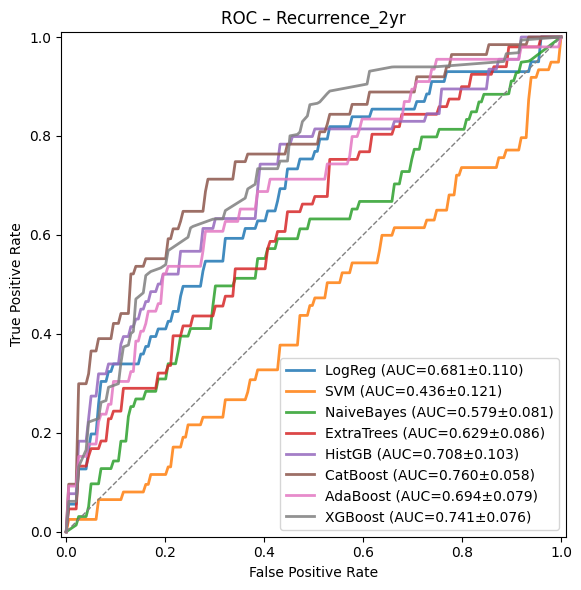

In [ ]:
# ╔═╡ Cell 7 ═════════════════════════════════════════════════════════════╗
# ------------- 7. Plot combined ROC figure -----------------------------
plt.figure(figsize=(8, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, disp in enumerate(roc_displays):
    disp.plot(ax=plt.gca(), alpha=0.85, linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)
plt.title("ROC – Recurrence_2yr")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 7b – Bootstrap AUC 95% CI ─────────────────────────────────╗
import numpy as np
from sklearn.metrics    import roc_auc_score

# 1) ground truth
y_true = y_test.reset_index(drop=True)

# 2) pipeline handles preprocessing internally
y_prob = models["XGBoost"].predict_proba(
    X_test.reset_index(drop=True)
)[:, 1]

# 3) bootstrap
n_bootstraps = 1000
rng = np.random.RandomState(42)
scores = []

for _ in range(n_bootstraps):
    idx = rng.randint(0, len(y_true), len(y_true))
    if len(np.unique(y_true.iloc[idx])) < 2:
        continue
    scores.append(roc_auc_score(y_true.iloc[idx], y_prob[idx]))

ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
auc_mean = roc_auc_score(y_true, y_prob)

print(f"AUC (test)         = {auc_mean:.3f}")
print(f"95% CI (bootstrap)= [{ci_lower:.3f}, {ci_upper:.3f}]")


AUC (test)         = 0.669
95% CI (bootstrap)= [0.526, 0.811]


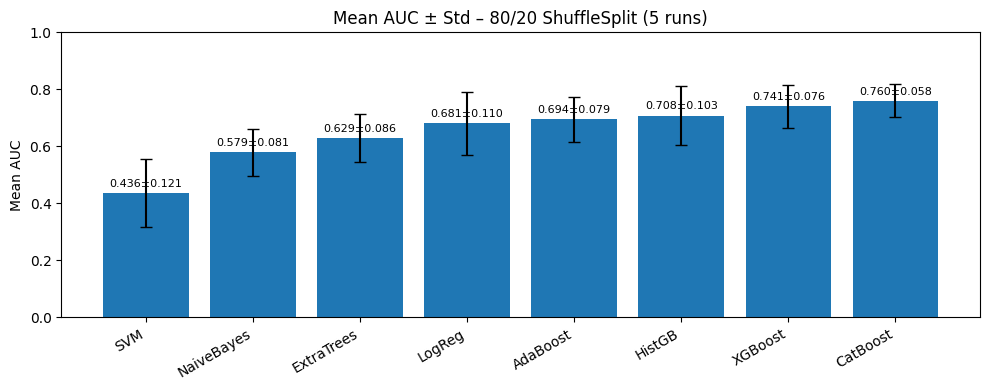

In [ ]:
# ╔═╡ Cell 8 – Bar chart of mean ShuffleSplit AUCs with ±std ─════════╗
import numpy as np

# 1. Compute mean & std per model
mean_aucs = {name: np.mean(vals) for name, vals in aucs.items()}
std_aucs  = {name: np.std(vals)  for name, vals in aucs.items()}

# 2. Sort by mean AUC
sorted_items = sorted(mean_aucs.items(), key=lambda kv: kv[1])
labels, means = zip(*sorted_items)
stds = [std_aucs[name] for name in labels]

# 3. Plot bars with error bars
plt.figure(figsize=(10, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=4)
plt.ylim(0, 1)
plt.ylabel("Mean AUC")
plt.title("Mean AUC ± Std – 80/20 ShuffleSplit (5 runs)")
plt.xticks(rotation=30, ha="right")

# 4. Annotate each bar with mean±std
for bar, m, s in zip(bars, means, stds):
    text = f"{m:.3f}±{s:.3f}"
    plt.annotate(
        text,
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3), textcoords="offset points",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 9 – Quick summary table with mean ± std AUC ─════════════╗
import numpy as np

# Build a list of records
records = []
for name, vals in aucs.items():
    records.append({
        "Model":    name,
        "Mean AUC": np.mean(vals),
        "Std AUC":  np.std(vals)
    })

# Create DataFrame and sort
summary = (
    pd.DataFrame(records)
      .sort_values("Mean AUC", ascending=False)
      .reset_index(drop=True)
)

# Plain‐text print
print(summary.to_string(index=False, float_format="%.3f"))


     Model  Mean AUC  Std AUC
  CatBoost     0.760    0.058
   XGBoost     0.741    0.076
    HistGB     0.708    0.103
  AdaBoost     0.694    0.079
    LogReg     0.681    0.110
ExtraTrees     0.629    0.086
NaiveBayes     0.579    0.081
       SVM     0.436    0.121


In [ ]:
# ╔═╡ Cell 9.5′ – Pipeline + sigmoid calibration ─────────────────────╗
from sklearn.pipeline            import Pipeline
from sklearn.calibration        import CalibratedClassifierCV
from xgboost                    import XGBClassifier

# 1) Rebuild a pipeline: preprocessing → XGBoost
xgb_pipe = Pipeline([
    ("prep", preprocessor),      # your ColumnTransformer!
    ("clf", XGBClassifier(
        n_estimators       = best_n_rounds,
        learning_rate      = 0.01,
        max_depth          = 5,
        subsample          = 0.8,
        colsample_bytree   = 0.8,
        gamma              = 1.0,
        reg_alpha          = 0.1,
        reg_lambda         = 1.0,
        scale_pos_weight   = (y_train==0).sum()/(y_train==1).sum(),
        objective          = "binary:logistic",
        eval_metric        = "auc",
        tree_method        = "hist",
        use_label_encoder  = False,
        random_state       = RANDOM_STATE
    ))
])

# 2) Wrap that in a sigmoid calibrator (Platt scaling) with 3-fold CV
calibrator = CalibratedClassifierCV(
    base_estimator = xgb_pipe,
    method         = "sigmoid",   # more stable on small samples
    cv             = 3            # internal 3-fold for calibration
)

# 3) Fit _only_ on your training set
calibrator.fit(X_train, y_train)

# 4) Save back into your models dict
models["XGBoost_Calibrated"] = calibrator


NameError: name 'best_n_rounds' is not defined

In [ ]:
# ╔═╡ Cell 10 – Calibration curve + Brier score ─────────────────══════╗
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss
import matplotlib.pyplot as plt

# 1) Raw probabilities (before calibration) on the raw X_test
y_prob_raw = models["XGBoost"].predict_proba(X_test)[:, 1]

# 2) Calibrated probabilities (same raw X_test)
y_prob_cal = models["XGBoost_Calibrated"].predict_proba(X_test)[:, 1]

# 3) Compute calibration curves (fraction of positives vs. mean predicted)
frac_pos_raw, mean_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_raw, frac_pos_raw, "s-", label="XGBoost (raw)")
plt.plot(mean_pred_cal, frac_pos_cal, "o-", label="XGBoost (calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Brier scores for raw vs. calibrated
print("Brier score (raw)     :", brier_score_loss(y_test, y_prob_raw))
print("Brier score (calibr.) :", brier_score_loss(y_test, y_prob_cal))


KeyError: 'XGBoost_Calibrated'

In [ ]:
# ╔═╡ Cell 11 – Precision–Recall & threshold‐tuning ════════════════╗
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = models["XGBoost"].predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="XGBoost PR-curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()

# F1 vs threshold
f1s = [f1_score(y_test, y_prob>=t) for t in thresholds]
opt_idx = np.argmax(f1s)
print(f"Best F1={f1s[opt_idx]:.3f} at threshold={thresholds[opt_idx]:.2f}")


In [ ]:
# ╔═╡ Cell 11 – SHAP summary plots for XGBoost ─══════════════════════╗
import shap
import matplotlib.pyplot as plt

# 1) Build a SHAP Explainer on your training set
explainer = shap.Explainer(models["XGBoost"], X_train)

# 2) Compute SHAP values on the test set: this returns an Explanation object
shap_values = explainer(X_test)

# 3) Beeswarm (dot) plot of per‐sample SHAP values
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("SHAP Beeswarm – XGBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 4) Bar plot of mean(|SHAP|) for each feature
plt.figure(figsize=(6, 8))
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title("mean(|SHAP|) – XGBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 12 – Partial dependence for top features ═══════════════╗
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) Extract the raw SHAP values array from the Explanation
#    shap_values was created in Cell 10 via `explainer(X_test)`
vals = shap_values.values
# If it’s a 3‐D array (n_samples x 2 classes x n_features),
# pick the positive‐class slice:
if vals.ndim == 3:
    vals = vals[:, 1, :]

# 2) Compute mean(|SHAP|) per feature and grab top-3 indices
importances = np.abs(vals).mean(axis=0)
top_idx    = np.argsort(importances)[::-1][:3]
top_feats  = [X_test.columns[i] for i in top_idx]

print("Top 3 features by |SHAP|:", top_feats)

# 3) Plot partial dependence for those top 3
fig, axes = plt.subplots(1, len(top_feats), figsize=(4*len(top_feats), 4))
PartialDependenceDisplay.from_estimator(
    models["XGBoost"],
    X_test,
    features=top_feats,
    ax=axes
)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 13 – Permutation importance ══════════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["XGBoost"], X_test, y_test,
    scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE
)
perm_df = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_df.head(10).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – XGBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 14 – Manual Decision Curve Analysis (Net Benefit) ─════════════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) True labels & predicted probabilities (from your best model)
y_true = y_test.values        # shape (n_samples,)
y_prob = models["XGBoost"].predict_proba(X_test)[:,1]

N      = len(y_true)
preval = y_true.mean()        # event rate

# 2) Define a grid of thresholds
thresholds = np.linspace(0.01, 0.99, 99)

# 3) Compute net benefit for each threshold
nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for pt in thresholds:
    preds = (y_prob >= pt).astype(int)
    TP    = ((preds == 1) & (y_true == 1)).sum()
    FP    = ((preds == 1) & (y_true == 0)).sum()
    # NB = TP/N - FP/N * (pt/(1-pt))
    nb    = TP/N - FP/N * (pt/(1-pt))
    nb_model.append(nb)
    nb_all.append(preval - (1 - preval)*(pt/(1-pt)))

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, nb_model, label="XGBoost")
plt.plot(thresholds, nb_all,   label="Treat All",    linestyle="--")
plt.plot(thresholds, nb_none,  label="Treat None",   linestyle=":")
plt.xlabel("Decision Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – Recurrence_2yr")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 15 – SHAP summary for CatBoost (Recurrence_2yr) ─════════════╗
import shap
import matplotlib.pyplot as plt

# 1) Prepare CatBoost-friendly data
X_test_cb = prepare_for_catboost(X_test, cat)

# 2) Build a TreeExplainer that can handle your string categories
explainer_cb = shap.TreeExplainer(
    models["CatBoost"],
    feature_perturbation="tree_path_dependent"
)

# 3) Compute the full SHAP matrix for the positive/recurrence class
shap_values_cb = explainer_cb.shap_values(X_test_cb)
# shap_values_cb should now be shape (n_samples, n_features)

print("🔎 SHAP values shape:", shap_values_cb.shape)

# 4) Beeswarm (dot) plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_cb,    # the full matrix, not a single row
    X_test_cb,
    max_display=20,
    show=False
)
plt.title("SHAP Beeswarm – CatBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 5) Bar plot of mean(|SHAP|) global importances
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values_cb,
    X_test_cb,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("mean(|SHAP|) – CatBoost")
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 16 – Partial dependence (top 3 CatBoost features) ═════════╗
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# pick the top 3 by mean(|SHAP|)
top3 = X_test_cb.columns[np.argsort(np.abs(shap_values_cb).mean(0))[-3:]]

fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
PartialDependenceDisplay.from_estimator(
    models["CatBoost"],      # your final CatBoost instance
    X_test_cb,               # preprocessed test set
    features=list(top3),     # names of the top 3
    ax=axes
)
plt.suptitle("Partial Dependence – CatBoost", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 17 – Permutation importance (CatBoost) ═════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["CatBoost"],
    X_test_cb, y_test,
    scoring="roc_auc",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# sort and plot
import pandas as pd
imp_df = pd.DataFrame({
    "feature": X_test_cb.columns,
    "mean_decrease_auc": r.importances_mean
}).sort_values("mean_decrease_auc", ascending=False).head(20)

plt.figure(figsize=(6,8))
plt.barh(imp_df["feature"][::-1], imp_df["mean_decrease_auc"][::-1])
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – CatBoost")
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 18 – Decision curve (CatBoost) ─────────────────────────────╗
import numpy as np
from sklearn.metrics import roc_curve

# (you can reuse your decision‐curve function or library)
# here’s a very simple “net benefit” curve for illustration:
probs = models["CatBoost"].predict_proba(X_test_cb)[:,1]
thresholds = np.linspace(0,1,100)
n = len(y_test)
event_rate = y_test.mean()

nb = []
for t in thresholds:
    tp = ((probs >= t) & (y_test==1)).sum()
    fp = ((probs >= t) & (y_test==0)).sum()
    nb.append((tp/n) - (fp/n)*(t/(1-t)))  # simple net‐benefit formula

plt.plot(thresholds, nb, label="CatBoost")
plt.plot(thresholds, np.zeros_like(thresholds), '--', label="Treat none")
plt.plot(thresholds,
         event_rate - (1-event_rate)*(thresholds/(1-thresholds)),
         ':', label="Treat all")
plt.xlabel("Decision threshold")
plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis – CatBoost")
plt.legend()
plt.tight_layout()
plt.show()
